In [2]:
# ------------------------- IMPORTACIONES -------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns    

In [3]:
df = pd.read_csv('HDHI Admission data.csv', sep=',')

In [4]:
# Inspección de primeras filas y resumen de columnas
df_info = {
    "shape": df.shape,
    "nombre de columnas": df.columns.tolist(),
    "tipo de datos":df.dtypes,
    "ejemplo de datos": df.head(3),
    "valores faltantes": df.isnull().sum().sort_values(ascending=False),
    "duplicados": df.duplicated().sum()
}

df_info

{'shape': (15757, 56),
 'nombre de columnas': ['SNO',
  'MRD No.',
  'D.O.A',
  'D.O.D',
  'AGE',
  'GENDER',
  'RURAL',
  'TYPE OF ADMISSION-EMERGENCY/OPD',
  'month year',
  'DURATION OF STAY',
  'duration of intensive unit stay',
  'OUTCOME',
  'SMOKING ',
  'ALCOHOL',
  'DM',
  'HTN',
  'CAD',
  'PRIOR CMP',
  'CKD',
  'HB',
  'TLC',
  'PLATELETS',
  'GLUCOSE',
  'UREA',
  'CREATININE',
  'BNP',
  'RAISED CARDIAC ENZYMES',
  'EF',
  'SEVERE ANAEMIA',
  'ANAEMIA',
  'STABLE ANGINA',
  'ACS',
  'STEMI',
  'ATYPICAL CHEST PAIN',
  'HEART FAILURE',
  'HFREF',
  'HFNEF',
  'VALVULAR',
  'CHB',
  'SSS',
  'AKI',
  'CVA INFRACT',
  'CVA BLEED',
  'AF',
  'VT',
  'PSVT',
  'CONGENITAL',
  'UTI',
  'NEURO CARDIOGENIC SYNCOPE',
  'ORTHOSTATIC',
  'INFECTIVE ENDOCARDITIS',
  'DVT',
  'CARDIOGENIC SHOCK',
  'SHOCK',
  'PULMONARY EMBOLISM',
  'CHEST INFECTION'],
 'tipo de datos': SNO                                 int64
 MRD No.                            object
 D.O.A                         

In [8]:
# Fechas convertidas a datetime
df['D.O.A_manual'] = df['D.O.A'].apply(lambda x: pd.to_datetime(x, errors='coerce', dayfirst=False))
df['D.O.A'] = df['D.O.A_manual']
df.drop(columns='D.O.A_manual', inplace=True)

# Verificar cuántas fechas nulas hay en cada una
nulos_doa = df['D.O.A'].isna().sum()

# Rango de fechas disponibles
min_doa = df['D.O.A'].min()
max_doa = df['D.O.A'].max()

duration_col = 'DURATION OF STAY'

# Ver estadísticas generales
duration_stats = df[duration_col].describe()

# Verificar valores negativos o inconsistentes
invalid_duration = df[df[duration_col] < 0]

duration_stats, invalid_duration.shape[0]


/var/folders/tm/_mcsvvpd5ml8xhw8l_7314j80000gn/T/ipykernel_57539/1322510359.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['D.O.A_manual'] = df['D.O.A'].apply(lambda x: pd.to_datetime(x, errors='coerce', dayfirst=False))


(count    15757.000000
 mean         6.415054
 std          5.011421
 min          1.000000
 25%          3.000000
 50%          5.000000
 75%          8.000000
 max         98.000000
 Name: DURATION OF STAY, dtype: float64,
 0)

Cantidad de registros y columnas: 15.757 filas y 56 columnas.
No se encontraron filas duplicadas.
No hay valores nulos en la columna de admisión (D.O.A).
Los datos abarcan desde el 4 de enero de 2017 hasta el 3 de diciembre de 2019.
Este rango permite trabajar con series temporales semanales o mensuales.
La estancia media es de aproximadamente 6.4 días.
El mínimo es 1 día y el máximo 98 días.
No se detectaron estancias con valores negativos.


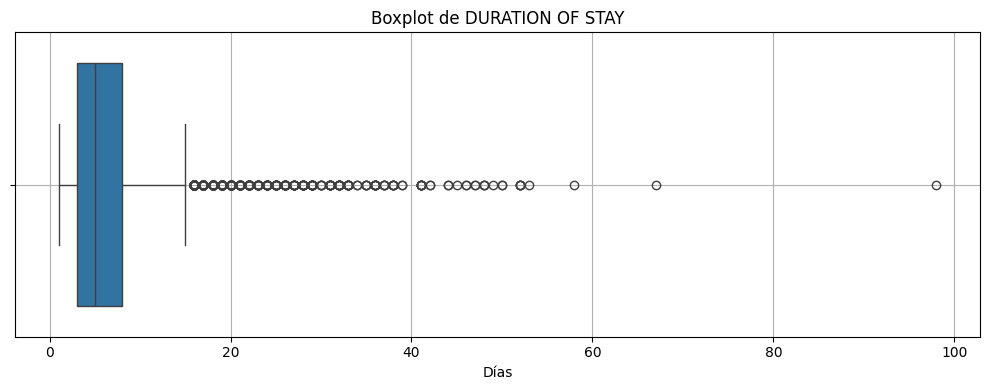

Outliers en 'DURATION OF STAY':
           D.O.A  DURATION OF STAY
3419  2017-01-10                45
4808  2017-01-12                16
4065  2017-02-11                33
25    2017-04-01                21
4     2017-04-01                23
...          ...               ...
15248 2019-10-03                16
14501 2019-11-02                22
15263 2019-11-03                22
15291 2019-12-03                17
15293 2019-12-03                17

[736 rows x 2 columns]


In [11]:
# Ordeno el dataset por fecha de admisión en orden ascendente
df = df.sort_values(by='D.O.A')
duration_data = df[duration_col].dropna()

# Diagrama de caja
plt.figure(figsize=(10, 4))
sns.boxplot(x=duration_data)
plt.title('Boxplot de DURATION OF STAY')
plt.xlabel('Días')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculo umbrales para detección de outliers (usando IQR)
Q1 = duration_data.quantile(0.25)
Q3 = duration_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifico outliers
df_outliers = df[(df[duration_col] < lower_bound) | (df[duration_col] > upper_bound)]

print("Outliers en 'DURATION OF STAY':")
print(df_outliers[['D.O.A', 'DURATION OF STAY']].sort_values('D.O.A'))

No se observa nada fuera de lo normal, puede estar identificando outiers a duraciones más largas de lo normal, pero esto no es un error, graficaré para hacer una observación más profunda

In [14]:
# pasar a numérico HB
df['HB'] = pd.to_numeric(df['HB'], errors='coerce')
conteo = (df['HB'] < 9).sum()

print(f"Número de registros con HB < 9: {conteo}")

Número de registros con HB < 9: 1339


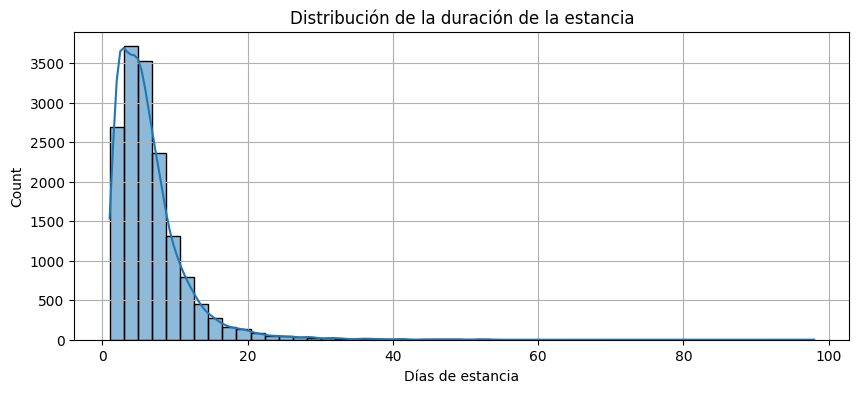

In [16]:
plt.figure(figsize=(10, 4))
sns.histplot(df['DURATION OF STAY'], bins=50, kde=True)
plt.title("Distribución de la duración de la estancia")
plt.xlabel("Días de estancia")
plt.grid(True)
plt.show()

In [18]:
# Convertir columnas relevantes a numérico, manejando valores no numéricos
numeric_cols = ['HB', 'DURATION OF STAY', 'duration of intensive unit stay', 'CREATININE', 'UREA', 'PLATELETS', 'BNP', 'EF']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear la variable proxy para transfusión
def create_transfusion_proxy(row):
    # Criterio principal: Hemoglobina baja (<8 g/dL) o anemia severa
    hb_condition = row['HB'] < 8 if pd.notna(row['HB']) else False
    severe_anemia_condition = row['SEVERE ANAEMIA'] == 1 if 'SEVERE ANAEMIA' in row else False
    
    # condiciones de gravedad que podrían requerir transfusión
    cva_bleed = row['CVA BLEED'] == 1 if 'CVA BLEED' in row else False
    stemi = row['STEMI'] == 1 if 'STEMI' in row else False
    cardiogenic_shock = row['CARDIOGENIC SHOCK'] == 1 if 'CARDIOGENIC SHOCK' in row else False
    shock = row['SHOCK'] == 1 if 'SHOCK' in row else False
    pulmonary_embolism = row['PULMONARY EMBOLISM'] == 1 if 'PULMONARY EMBOLISM' in row else False
    ckd = row['CKD'] == 1 if 'CKD' in row else False
    emergencia = row['TYPE OF ADMISSION-EMERGENCY/OPD']=='E' if 'TYPE OF ADMISSION-EMERGENCY/OPD' in row else False
    
    # Duración de la estancia (>7 días) o estancia en UCI (>1 días)
    long_stay = row['DURATION OF STAY'] > 7 if pd.notna(row['DURATION OF STAY']) else False
    icu_stay = row['duration of intensive unit stay'] > 1 if pd.notna(row['duration of intensive unit stay']) else False
    
    # Lógica para la variable proxy:
    # Necesita transfusión si:
    # HB < 9 o SEVERE ANAEMIA == 1
    # si hay condiciones graves (CVA BLEED, STEMI, SHOCK) con HB < 10
    # si hay CKD con HB < 9
    if (hb_condition or severe_anemia_condition or
        (row['HB'] < 10 and pd.notna(row['HB']) and (cva_bleed or stemi or cardiogenic_shock or shock or pulmonary_embolism)) or
        (ckd and row['HB'] < 9 and pd.notna(row['HB'])) or 
        (emergencia) or
        (long_stay and icu_stay and row['HB'] < 10 and pd.notna(row['HB']))):
        return 1
    return 0

# Aplicar la función para crear la columna 'needs_transfusion'
df['needs_transfusion'] = df.apply(create_transfusion_proxy, axis=1)

# Resumen de la variable proxy
print("Resumen de la variable proxy 'needs_transfusion':")
print(df['needs_transfusion'].value_counts())
print(f"Porcentaje de pacientes que necesitaron transfusión: {(df['needs_transfusion'].sum() / len(df)) * 100:.2f}%")


Resumen de la variable proxy 'needs_transfusion':
needs_transfusion
1    11238
0     4519
Name: count, dtype: int64
Porcentaje de pacientes que necesitaron transfusión: 71.32%


In [20]:
# Asignar Blood Type
np.random.seed(42)

# Asignar tipos de sangre con distribución ajustada para India
blood_types = ['A+', 'A-', 'B+', 'B-', 'O+', 'O-', 'AB+', 'AB-']
probabilities = [0.21, 0.02, 0.33, 0.02, 0.32, 0.02, 0.07, 0.01]
         
df['Blood Type'] = np.random.choice(blood_types, size=len(df), p=probabilities)

# Verificar la distribución de los tipos de sangre generados
print("Distribución de tipos de sangre en el dataset (%):")
print(df['Blood Type'].value_counts(normalize=True).sort_index() * 100)

Distribución de tipos de sangre en el dataset (%):
Blood Type
A+     21.349242
A-      1.980072
AB+     7.044488
AB-     0.913880
B+     33.375643
B-      1.935648
O+     31.611347
O-      1.789681
Name: proportion, dtype: float64


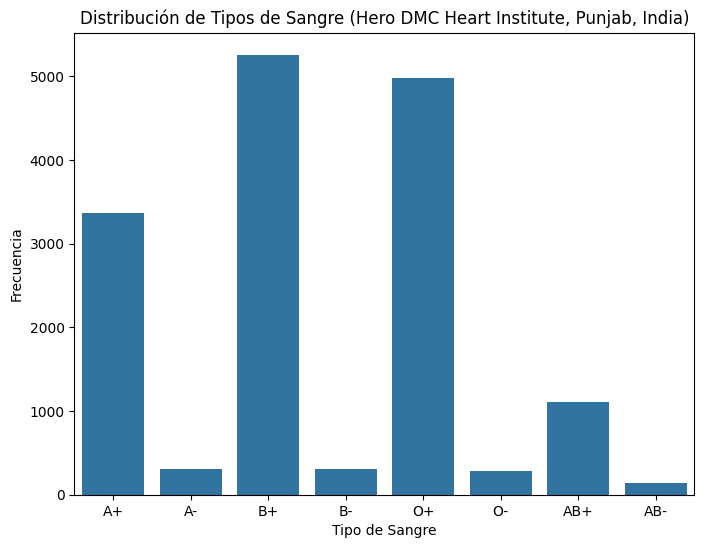

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Blood Type', data=df, order=blood_types)
plt.title('Distribución de Tipos de Sangre (Hero DMC Heart Institute, Punjab, India)')
plt.xlabel('Tipo de Sangre')
plt.ylabel('Frecuencia')
plt.show()

In [24]:
# Elimino variables para trabajar con un conjunto de datos con los datos relevantes para este trabajo
cols_utiles = ['D.O.A', 'DURATION OF STAY', 'needs_transfusion', 'Blood Type']

# Filtrar el DataFrame conservando solo esas columnas
df = df[cols_utiles].copy()

In [26]:
df.columns

Index(['D.O.A', 'DURATION OF STAY', 'needs_transfusion', 'Blood Type'], dtype='object')

In [28]:
print(df['needs_transfusion'].value_counts(normalize=True) * 100)

needs_transfusion
1    71.320683
0    28.679317
Name: proportion, dtype: float64


In [30]:
df.head(100)

,D.O.A,DURATION OF STAY,needs_transfusion,Blood Type
16,2017-01-04,3,0,B+
3405,2017-01-10,10,1,AB+
3419,2017-01-10,45,0,O+
4047,2017-01-11,3,1,O+
4032,2017-01-11,2,0,A+
...,...,...,...,...
33,2017-04-02,4,1,B+
32,2017-04-02,1,1,B+
31,2017-04-02,2,1,B+
37,2017-04-02,23,1,A+


In [32]:
# Ahora realizaré un análisis para saber que tipo de comportamiento tiene needs_transfusion en el tiempo
weekly_transfusions = (
    df[df['needs_transfusion'] == 1]
    .groupby(df['D.O.A'].dt.to_period('W').apply(lambda r: r.start_time))['needs_transfusion']
    .count()
    .reset_index(name='weekly_count')
)

weekly_transfusions['D.O.A'] = pd.to_datetime(weekly_transfusions['D.O.A'])

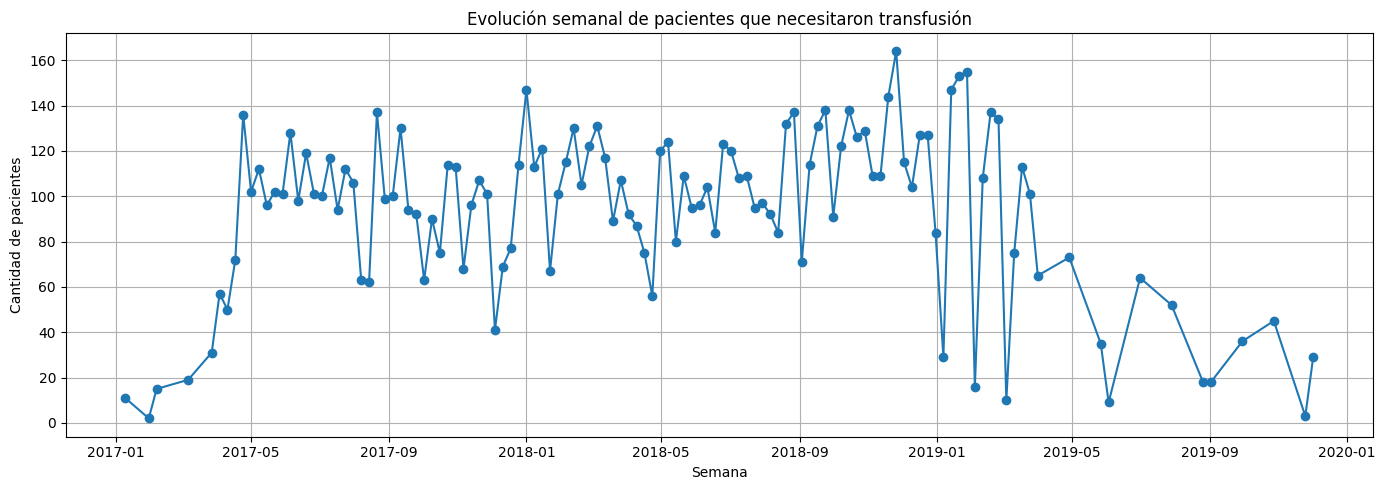

In [34]:
plt.figure(figsize=(14, 5))
plt.plot(weekly_transfusions['D.O.A'], weekly_transfusions['weekly_count'], marker='o')
plt.title('Evolución semanal de pacientes que necesitaron transfusión')
plt.xlabel('Semana')
plt.ylabel('Cantidad de pacientes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Función para seleccionar rango denso de fechas
def detectar_rango_denso(df_org, date_col='D.O.A', min_por_semana=10, buffer_semanas=2):
    df_tmp = df_org.copy()
    df_tmp[date_col] = pd.to_datetime(df_tmp[date_col], errors='coerce')
    weekly_counts = df_tmp.groupby(df_tmp[date_col].dt.to_period('W').apply(lambda r: r.start_time)).size()
    weeks_valid = weekly_counts[weekly_counts >= min_por_semana]
    if weeks_valid.empty:
        return None  # No hay rango denso suficiente
    start = weeks_valid.index.min() - pd.Timedelta(weeks=buffer_semanas)
    end = weeks_valid.index.max() + pd.Timedelta(weeks=buffer_semanas)
    return start, end

rango = detectar_rango_denso(df, min_por_semana=20)

# Aplicar filtro al dataframe original si hay rango válido
if rango:
    df_filtrado = df[
        (df['D.O.A'] > rango[0]) &
        (df['D.O.A'] <= rango[1])
    ]
else:
    df_filtrado = pd.DataFrame()  # sin datos útiles

df = df_filtrado.copy()
weekly_transfusions = (
    df[df['needs_transfusion'] == 1]
    .groupby(df['D.O.A'].dt.to_period('W').apply(lambda r: r.start_time))['needs_transfusion']
    .count()
    .reset_index(name='weekly_count')
)

weekly_transfusions['D.O.A'] = pd.to_datetime(weekly_transfusions['D.O.A'])

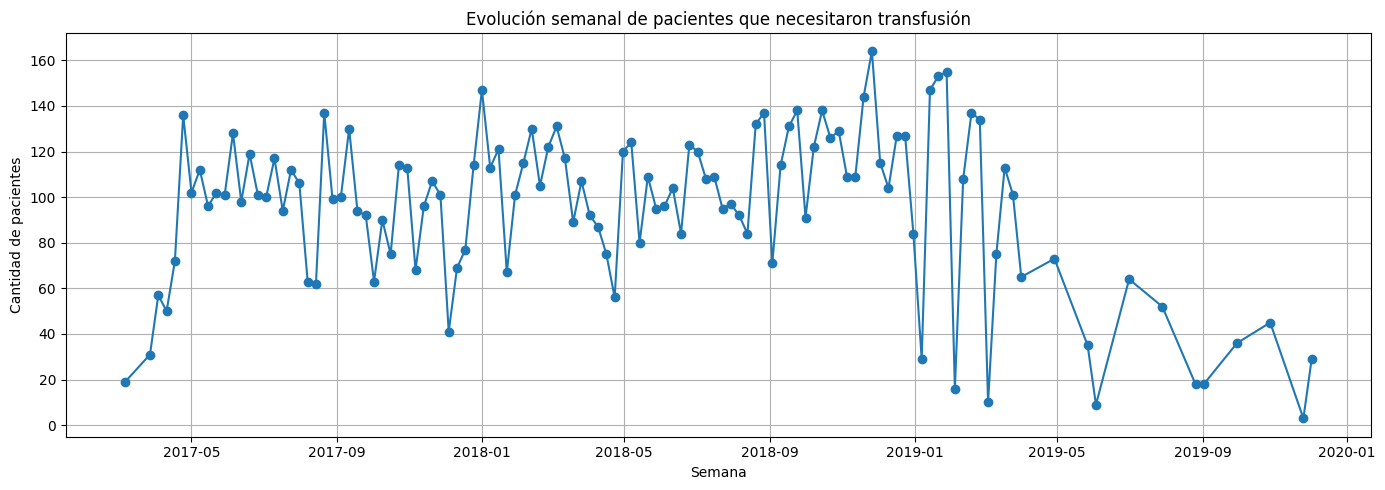

In [38]:
plt.figure(figsize=(14, 5))
plt.plot(weekly_transfusions['D.O.A'], weekly_transfusions['weekly_count'], marker='o')
plt.title('Evolución semanal de pacientes que necesitaron transfusión')
plt.xlabel('Semana')
plt.ylabel('Cantidad de pacientes')
plt.grid(True)
plt.tight_layout()
plt.show()

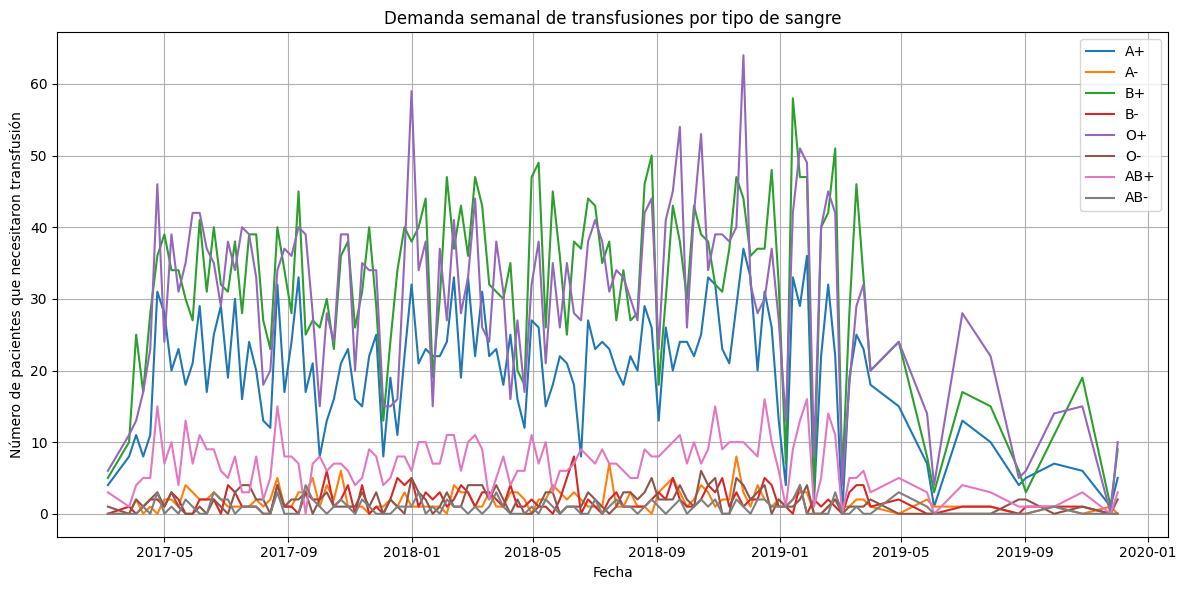

In [40]:
# Agrupo por semana y tipo de sangre
df = df[df['needs_transfusion'] == 1]
weekly_demand = df.groupby([df['D.O.A'].dt.to_period('W').apply(lambda r: r.start_time), 'Blood Type'])['needs_transfusion'].sum().unstack().fillna(0)

plt.figure(figsize=(12, 6))
for bt in blood_types:
    plt.plot(weekly_demand.index, weekly_demand[bt], label=bt)

plt.title("Demanda semanal de transfusiones por tipo de sangre")
plt.xlabel("Fecha")
plt.ylabel("Número de pacientes que necesitaron transfusión")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


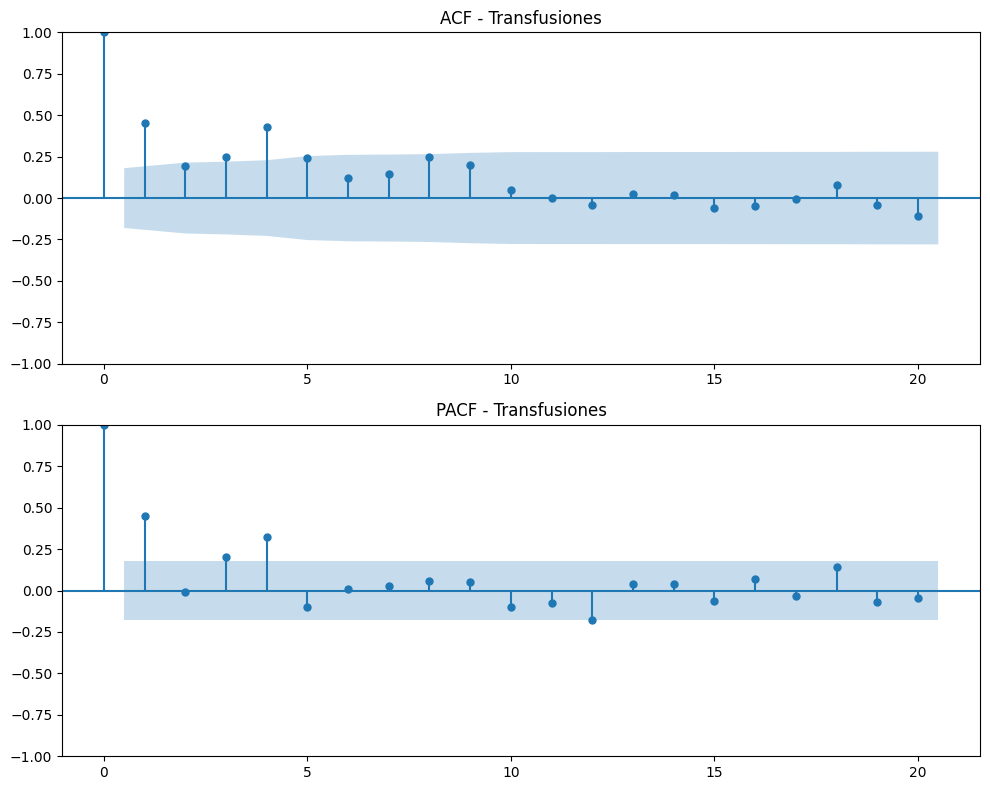

{'ADF Statistic': -2.1940781645837366,
 'p-value': 0.20840175792212118,
 'Lags Used': 3,
 'Observations': 114,
 'Critical Values': {'1%': -3.489057523907491,
  '5%': -2.887246327182993,
  '10%': -2.5804808802708528}}

In [49]:
serie = weekly_transfusions['weekly_count']
adf_result = adfuller(serie)

# Graficar ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(serie, lags=20, ax=axes[0])
axes[0].set_title("ACF - Transfusiones")

plot_pacf(serie, lags=20, ax=axes[1], method='ywm')
axes[1].set_title("PACF - Transfusiones")

plt.tight_layout()
plt.show()

# Resultado ADF
adf_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Lags Used": adf_result[2],
    "Observations": adf_result[3],
    "Critical Values": adf_result[4]
}

adf_output

En el gráfico de autocorrelación los primeros lags (1, 2, 3...) muestran una autocorrelación positiva significativa, La autocorrelación disminuye de a poco , lo que puede indicar una tendencia en el tiempo. En el gráfico de autocorrelación parcial se puede ver en los primeros lags que la semana anterior influye directamente. El lag 2 también es moderadamente alto, pero luego cae a valores cercanos a 0, lo que indica que no hay influencia directa de semanas más atrás en el tiempo una vez controlado por los primeros lags.